# **Домашняя работа №4.**

Максимальная оценка - 10 баллов.

Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы.

Задание состоит из двух разделов:
1. В первом разделе вам нужно вычислить энтропию и информационный выигрыш для простых примеров. Максимальный балл в этой части: **4 балла**.
2. Во втором разделе вы научитесь применять деревья из sklearn для задачи классификации. На примере различных метрик вы посмотрите на качество своей модели. Дополнительно вы посмотрите на стандартные примеры датасетов из sklearn и на то, как дерево с ними справится. Максимальный балл в этой части: **6 баллов**.

Загрузим необходимые библиотеки:

In [291]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (9, 6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [292]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

In [293]:
#!pip install mlxtend
from mlxtend.plotting import plot_decision_regions

## **Часть 1**

На лекции и семинарах вы изучали такие понятия, как энтропия и информационный выигрыш. Сейчас мы попрактикуемся в их вычислении.

Напомним, что **энтропия Шеннона** вычисляется следующим образом по N возможному числу состояний:

$$\large S = - \sum_{i=1}^N p_i log_2 p_i$$

где $p_i$ - вероятность найти систему в i-ом состоянии.

Рассмотрим пример. Пусть дана система (датасет), в которой определены два состояния (вероятности). Первое $\large p_1=\frac{3}{7}$ и второе $\large p_2=\frac{4}{7}$. Тогда энтропия вычисляется так:

$\large S_0=−\frac{3}{7} * log_2 \frac{3}{7} - \frac{4}{7} * log_2 \frac{4}{7} ≈ 0.9852$

Теперь рассмотрим случай, когда систему (датасет) поделили относительно некоторого признака. На левую часть и на правую. Чему теперь равна энтропия каждой из частей? И чему будет равен информационный выигрыш при таком делении?

Энтропия левой части равна: $\normalsize S_1=−\frac{1}{4} * log_2 \frac{1}{4} - \frac{3}{4} * log_2 \frac{3}{4} ≈ 0.8113$.

Энтропия правой части равна: $\normalsize S_2=−\frac{2}{3} * log_2 \frac{2}{3} - \frac{1}{3} * log_2 \frac{1}{3} ≈ 0.9183$.

Как вы можете видеть, значение энтропии стало меньше в двух группах. Особенно в левой группе. Посколько энтропия является мерой хаоса (или неопределённости) в системе, то мы говорим, что информационный выигрыш характеризуется уменьшением энтропии.

Информационный выигрыш (Information Gain, IG) для разделения на основе признака Q выглядит следующим образом:

$$\large IG(Q)=S_0 - \sum_{i=1}^q\frac{N_i}{N} S_i$$

где $q$ - число групп после деления, $N_i$ - количество объектов в выборке, в которой признак $Q$ равен i-ому значению.

**Информационный выигрыш = сколько энтропии мы удалили**, поэтому для нашего примера:

$$\normalsize IG=0.985 − (\frac{3}{7} * 0.9183 + \frac{4}{7} * 0.8113) ≈ 0.985 - 0.857 = 0.128 $$

Теперь напишем функции для вычисления энтропии и информационного выигрыша.

Рассмотрим следующий простой пример: у нас есть 9 синий и 11 жёлтых мячей. Пусть мяч будет иметь метку **1**, если он синий, **0** в противном случае.

In [294]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<img src = 'https://habrastorage.org/webt/mu/vl/mt/muvlmtd2njeqf18trbldenpqvnm.png'>

Затем разделим мячи на две группы по некоторому признаку:

<img src='https://habrastorage.org/webt/bd/aq/5w/bdaq5wi3c4feezaexponvin8wmo.png'>

In [295]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 жёлтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 жёлтых
balls_left, balls_right

([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0])

### **Задание 1 (1 балл).**

Напишите функцию, вычисляющую энтропию по Шеннону. И примените её для для следующих наборов данных.

In [296]:
def entropy(list_):
    total_objects = len(list_)
    dict_ = {i: 0 for i in set(list_)}
    for element in list_:
        dict_[element] += 1
    def log2(x):
        return np.log(x) / np.log(2)
    entropy_for_objects = [(dict_[i]/total_objects)*log2(dict_[i]/total_objects) for i in dict_]
    return sum(entropy_for_objects)*(-1)

Проверка:

In [297]:
print(entropy(balls)) # 9 синих и 11 жёлтых
print(entropy(balls_left)) # 8 синих и 5 жёлтых
print(entropy(balls_right)) # 1 синий и 6 жёлтых

0.9927744539878084
0.961236604722876
0.5916727785823275


### **Задание 2 (1 балл).**

Чему равна энтропия бросания монетки (без учёта ребра и с равными вероятностями для сторон монетки)?

In [298]:
print(entropy([0, 1]))
# Энтропия равна 1
# Можем считать что считаем энтропию от массива [0, 1], где 0 - орел, 1 - решка, они равновероятны

1.0


### **Задание 3 (1 балл).**

Чему равна энтропия игральной кости (мы рассматриваем игральную кость, как систему с 6 равновероятными состояниями)?

In [299]:
print(entropy([1, 2, 3, 4, 5, 6]))
# Можем считать что считаем энтропию от массива [1, 2, 3, 4, 5, 6], где каждое элемент это число выпавшее при бросании кости, все они равновероятны

2.584962500721156


### **Задание 4 (1 балл).**

Напишите функцию, которая вычисляет информационный выигрыш при делении исходных данных на **balls_left** and **balls_right** ?

In [300]:
# вычисление информационного выигрыша

def information_gain(full_data, left, right):
    ''' full_data - исходные данные, left и right - две части исходных данных'''
    entropy_full = entropy(full_data)
    entropy_left = entropy(left)
    entropy_right = entropy(right)
    return entropy_full - (len(left)/len(full_data))*entropy_left - (len(right)/len(full_data))*entropy_right


Проверка:

In [301]:
print(round(information_gain(balls, balls_left, balls_right), 3))

0.161


## **Часть 2**

В этой части мы рассмотрим дерево из sklearn на примере задачи классификации. В качестве данных мы возьмём The "Adult" Dataset.

Сначала сделаем предобработку данных, затем приступим к обучению модели.

Описание датасета:

[Dataset](https://www.kaggle.com/datasets/sagnikpatra/uci-adult-census-data-dataset) UCI Adult (файлы не нужно загружать, они доступны в репозитории данного курса ): классификация людей на основе демографических данных - зарабатывает ли человек более \$50,000 в год или нет.

Описание входных признаков:

- **Age** – непрерывный признак
- **Workclass** –  непрерывный признак
- **fnlwgt** – конечный вес объекта, непрерывный признак
- **Education** –  категориальный признак
- **Education_Num** – количество лет образования, непрерывный признак
- **Martial_Status** –  категориальный признак
- **Occupation** –  категориальный признак
- **Relationship** – категориальный признак
- **Race** – категориальный признак
- **Sex** – категориальный признак
- **Capital_Gain** – непрерывный признак
- **Capital_Loss** – непрерывный признак
- **Hours_per_week** – непрерывный признак
- **Country** – категориальный признак

**Target** – уровень дохода, категориальный (бинарный) признак.

Датасет состоит из двух файлов: для обучения и для тестирования.

In [302]:
!wget -O 'adult_train.csv' -q https://github.com/hse-ds/ml-hse-nes/blob/main/2024/homeworks/homework_4/adult_train.csv?raw=true

In [303]:
!wget -O 'adult_test.csv' -q https://github.com/hse-ds/ml-hse-nes/blob/main/2024/homeworks/homework_4/adult_test.csv?raw=true

In [304]:
data_train = pd.read_csv('adult_train.csv')

In [305]:
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [306]:
data_test = pd.read_csv('adult_test.csv')

In [307]:
data_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [308]:
# удаляем строчки с неверными метками в тестовых данных
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# кодируем целевую переменную как целое число
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

In [309]:
data_train.isna().sum()

,0
Age,0
Workclass,1836
fnlwgt,0
Education,0
Education_Num,0
Martial_Status,0
Occupation,1843
Relationship,0
Race,0
Sex,0


In [310]:
data_test.isna().sum()

,0
Age,0
Workclass,963
fnlwgt,0
Education,0
Education_Num,0
Martial_Status,0
Occupation,966
Relationship,0
Race,0
Sex,0


Первичный анализ датасета.

In [311]:
data_test.describe()

,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
count,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [312]:
data_train['Target'].value_counts()

,count
Target,
0,24720
1,7841


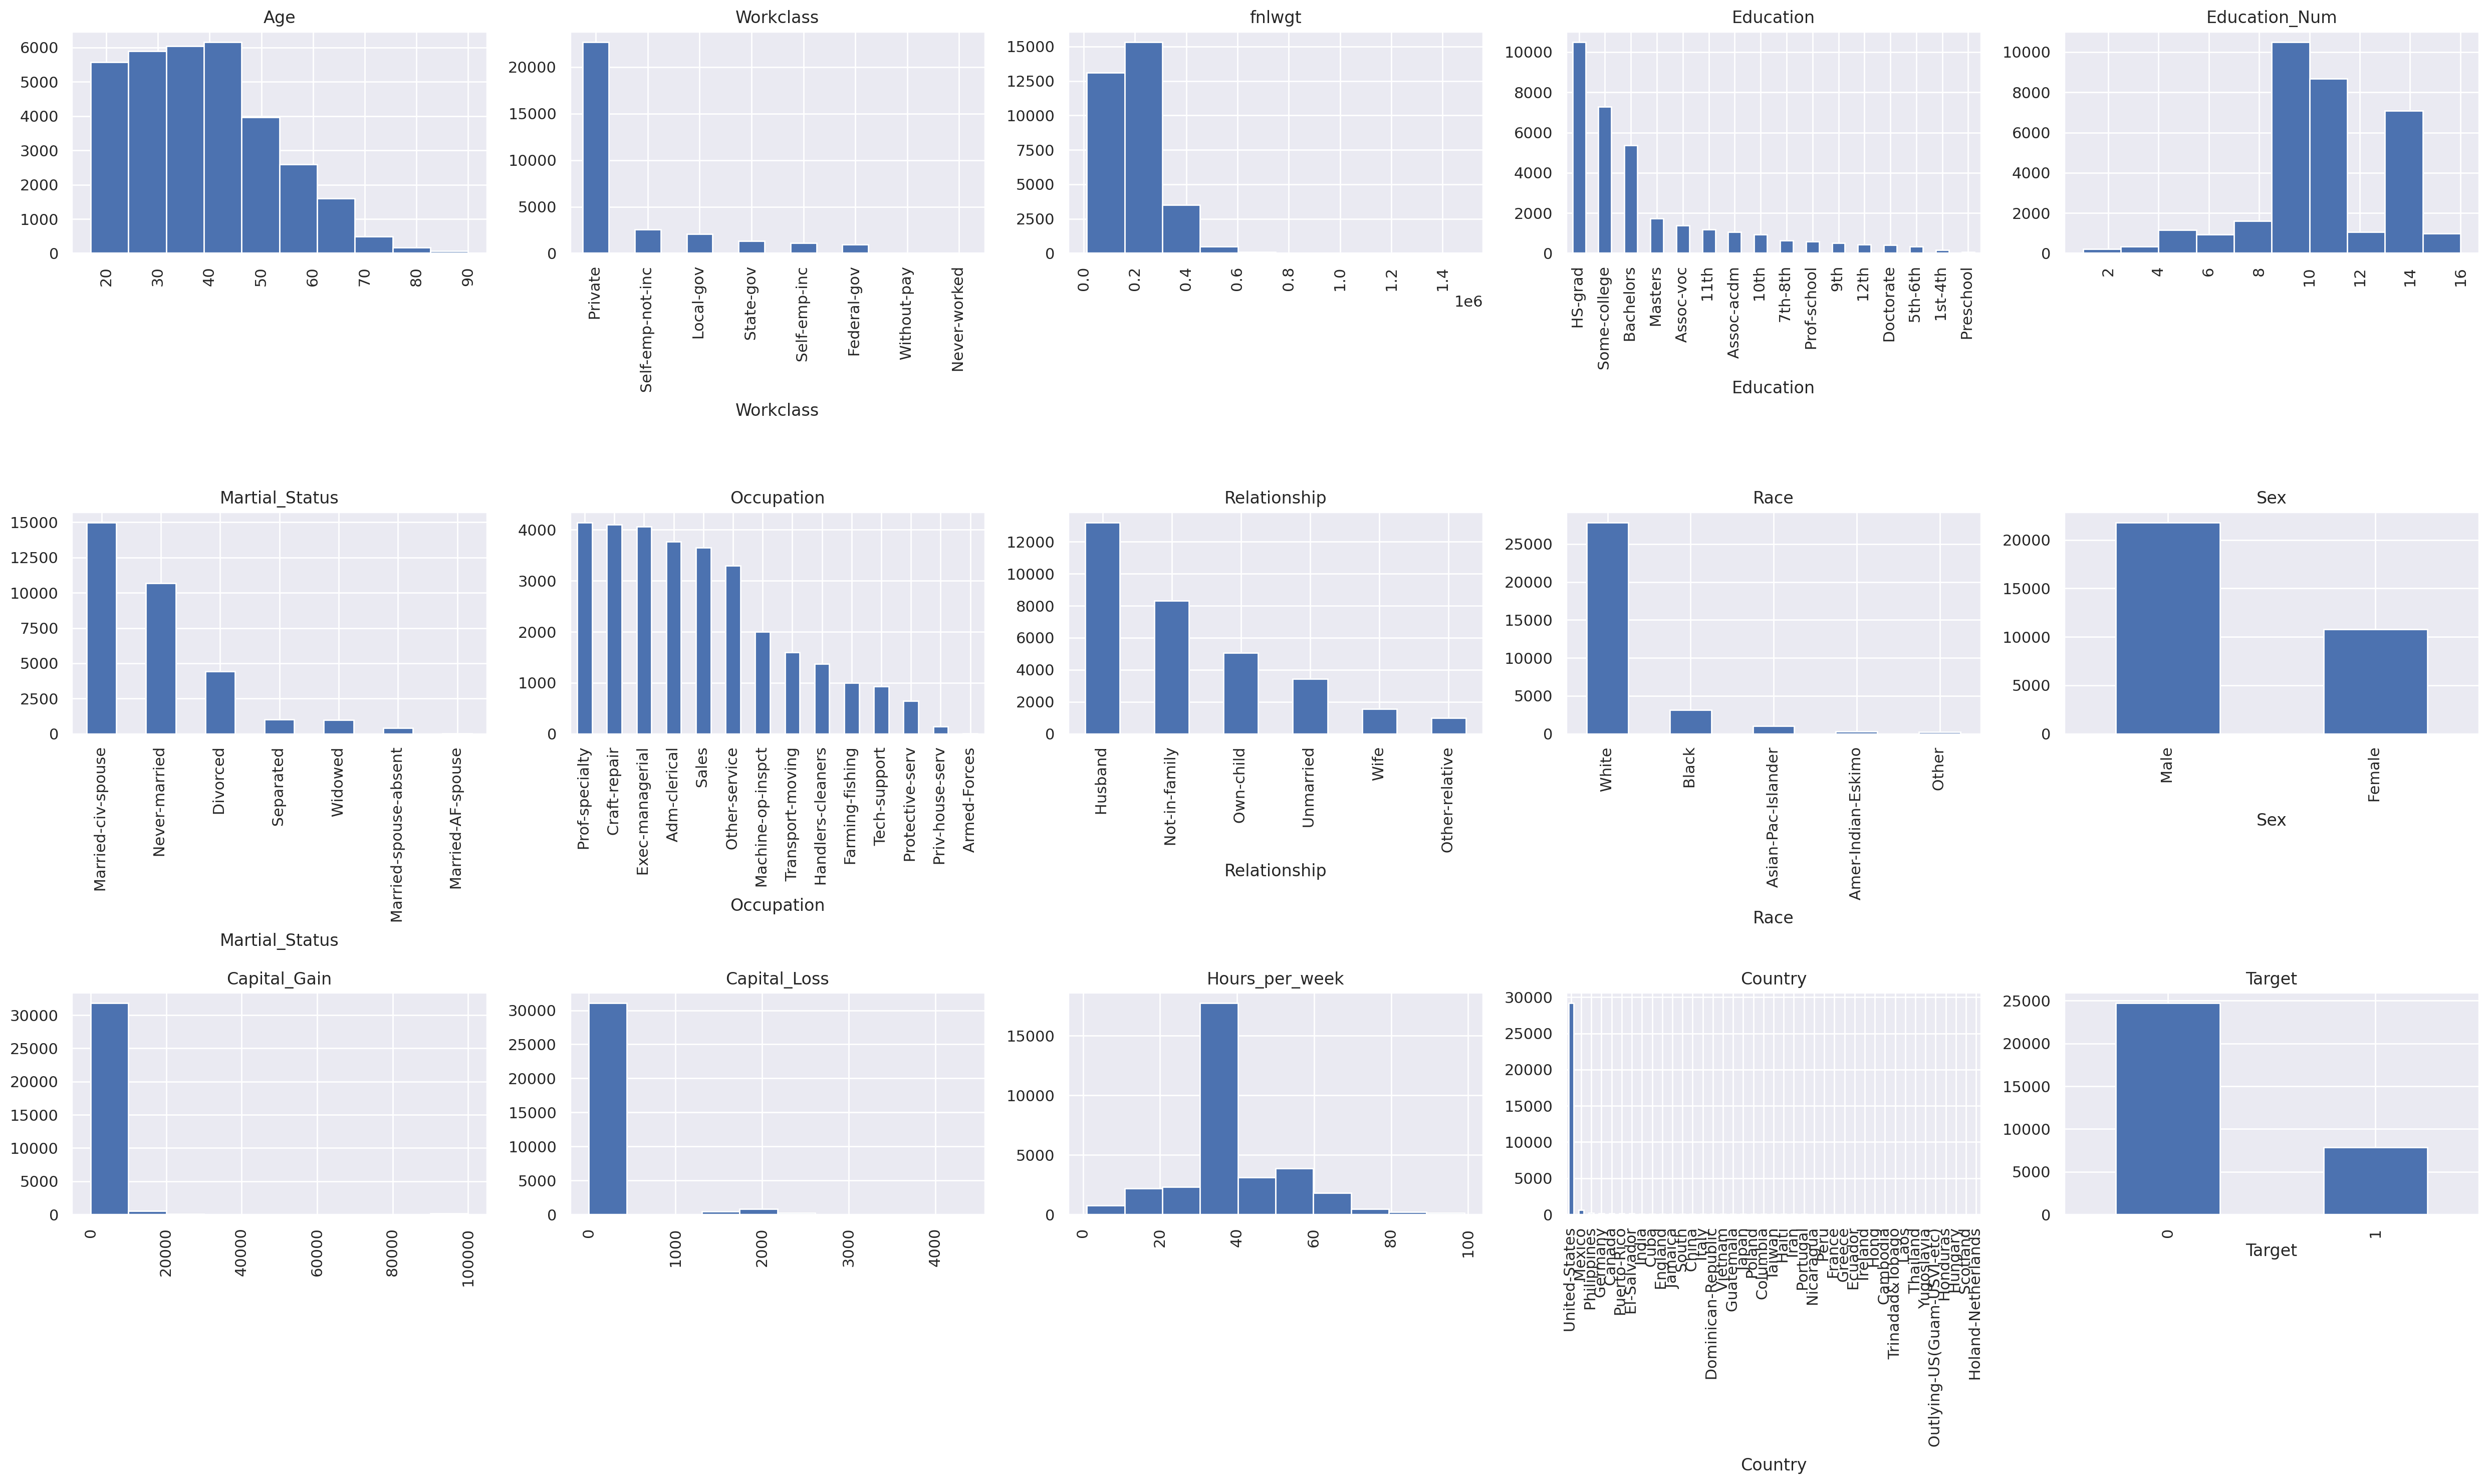

In [313]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.tight_layout()

Давайте посмотрим на типы данных в наших датасетах.

In [314]:
data_train.dtypes

,0
Age,int64
Workclass,object
fnlwgt,int64
Education,object
Education_Num,int64
Martial_Status,object
Occupation,object
Relationship,object
Race,object
Sex,object


In [315]:
data_test.dtypes

,0
Age,object
Workclass,object
fnlwgt,float64
Education,object
Education_Num,float64
Martial_Status,object
Occupation,object
Relationship,object
Race,object
Sex,object


Как мы видим, в тестовых данных признак Age рассматривается, как тип **object**. Нам нужно это исправить.

In [316]:
data_test['Age'] = data_test['Age'].astype(int)

Также мы приведём все признаки с типами **float** к типам **int**, чтобы обеспечить согласованность типов между нашими обучающими и тестовыми данными.

In [317]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

Мы заполним пропущенные значения медианами для непрерывных признаков и модами для категориальных.

In [318]:
# выбираем категориальные и непрерывные признаки из данных

categorical_columns = [c for c in data_train.columns
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [319]:
# можно заметить пропущенные значения
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [320]:
# заполняем пропущенные значения
for c in categorical_columns:
    data_train[c] = data_train[c].fillna(data_train[c].mode()[0])
    data_test[c] = data_test[c].fillna(data_test[c].mode()[0])

for c in numerical_columns:
    data_train[c] = data_train[c].fillna(data_train[c].median())
    data_test[c] = data_test[c].fillna(data_test[c].median())

In [321]:
# пропусков нет
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


Закодируем некоторые категориальные признаки: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. Это можно сделать с помощью метода `get_dummies` в pandas.

In [322]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [323]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [324]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

Тут вы можете заметить, что одного признака нет в тестовых данных. Можно создать новый нулевой признак.

In [325]:
data_test['Country_ Holand-Netherlands'] = 0

In [326]:
set(data_train.columns) - set(data_test.columns)

set()

In [327]:
data_train.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [328]:
data_test.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0


Однако теперь видим, что порядок признаков в двух наборах данных может быть нарушен. Чтобы модель при предсказании не ругалась на это (порядок признаков в обучении и тестировании должен совпадать), можно выполнить следующее действие.

In [329]:
data_train = pd.concat([data_train.drop(['Country_ Holand-Netherlands'], axis=1), data_train['Country_ Holand-Netherlands']], axis=1)

In [330]:
data_train.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [331]:
data_test.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [332]:
data_train.shape, data_test.shape

((32561, 106), (16281, 106))

In [333]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']


Рассмотрим решающее дерево без оптимизации гиперпараметров.

### **Задание 5 (2 балла).**

Обучите `DecisionTreeClassifier` с глубиной равной 3. Используйте параметр `random_state = 17` для воспроизводства результатов. Получите гиперпараметры из модели. Получите оценку меток классов и вероятностей классов. Для проверки качества модели посчитайте следующие метрики на тестовых данных: `Accuracy`, `Precision`, `Recall` и `F1`. Какой можно сделать вывод на основе полученных значений?

In [334]:
tree_clf = DecisionTreeClassifier(random_state=17, max_depth=3)

Гиперпараметры вашей модели:

In [335]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

Сделайте предсказание обученной модели на тестовых данных.

In [336]:
tree_clf.fit(X_train, y_train)

tree_predictions = tree_clf.predict(X_test)
tree_predictions_proba = tree_clf.predict_proba(X_test)

In [337]:
tree_predictions[:5]

array([0, 0, 0, 1, 0])

In [338]:
tree_predictions_proba[:5]

array([[0.97533179, 0.02466821],
       [0.70327688, 0.29672312],
       [0.70327688, 0.29672312],
       [0.02083333, 0.97916667],
       [0.97533179, 0.02466821]])

Какова точность (`Accuracy`) такого решающего дерева? Тоже самое сделайте для других метрик. Можно ли что-то сказать про сбалансированных классов?

In [339]:
accuracy = accuracy_score(y_test, tree_predictions)
precision = precision_score(y_test, tree_predictions)
recall = recall_score(y_test, tree_predictions)
f1 = f1_score(y_test, tree_predictions)

print(f'Accuracy: {accuracy}') # 0.845
print(f'Precision: {precision}') # 0.756
print(f'Recall: {recall}') # 0.507
print(f'F1: {f1}') # 0.607

# Accuracy в целом хороший, а вот остальные метрики не очень, особенно recall, дерево делает очень много ложных предсказаний 0 (то есть плохо предсказывает единицы).
# На тестовой выборке можно предположить, что классы несбалансированы, так как все precision сильно отклоняется от recall,
# это согласуется с данными выше, которые показывают, что дисбаланс действительно есть, единиц намного меньше (и на тестовой, и на всей)


Accuracy: 0.8447884036607088
Precision: 0.7555211158465711
Recall: 0.5070202808112324
F1: 0.6068149992220321


### **Задание 6 (2 балла).**

* Нарисуйте ROC-кривую и посчитайте AUC ROC для неё. Какие можно сделать выводы?

* Также нарисуйте Precision-Recall-кривую и посчитайте Average Precision метрику для неё. Какие здесь можно сделать выводы?

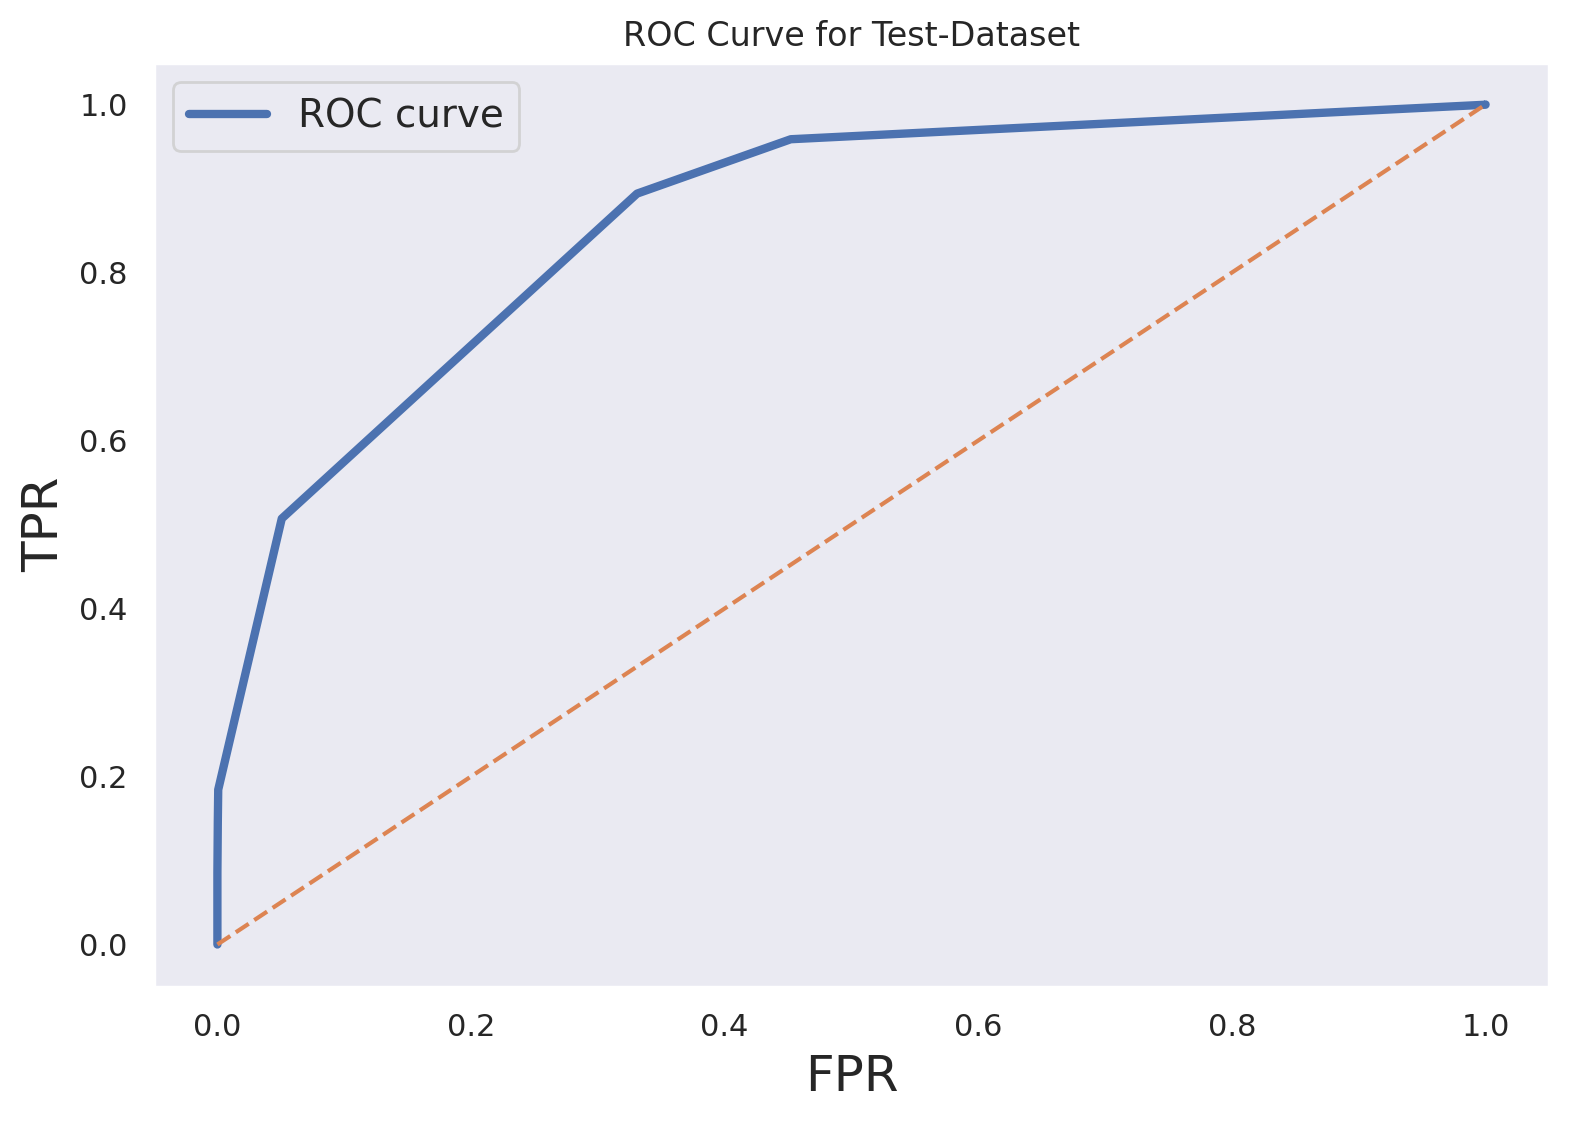

In [340]:
fpr, tpr, _ = roc_curve(y_test, tree_predictions_proba[:, 1])

plt.plot(fpr, tpr, linewidth=3, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve for Test-Dataset')
plt.xlabel('FPR', size=18)
plt.ylabel('TPR', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

In [341]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(f'ROC AUC: {auc}')  # 0.86

# Неплохая величина Roc Auc, модель достаточно хорошо работает, но сама кривая очень негладкая,
# это говорит об маленьком количестве пороговых вероятностей модели
# скорее всего ситуацию можно исправить, если увеличить максимальную глубину дерева, вероятно это увеличит и эффективность модели

ROC AUC: 0.8624154495733508


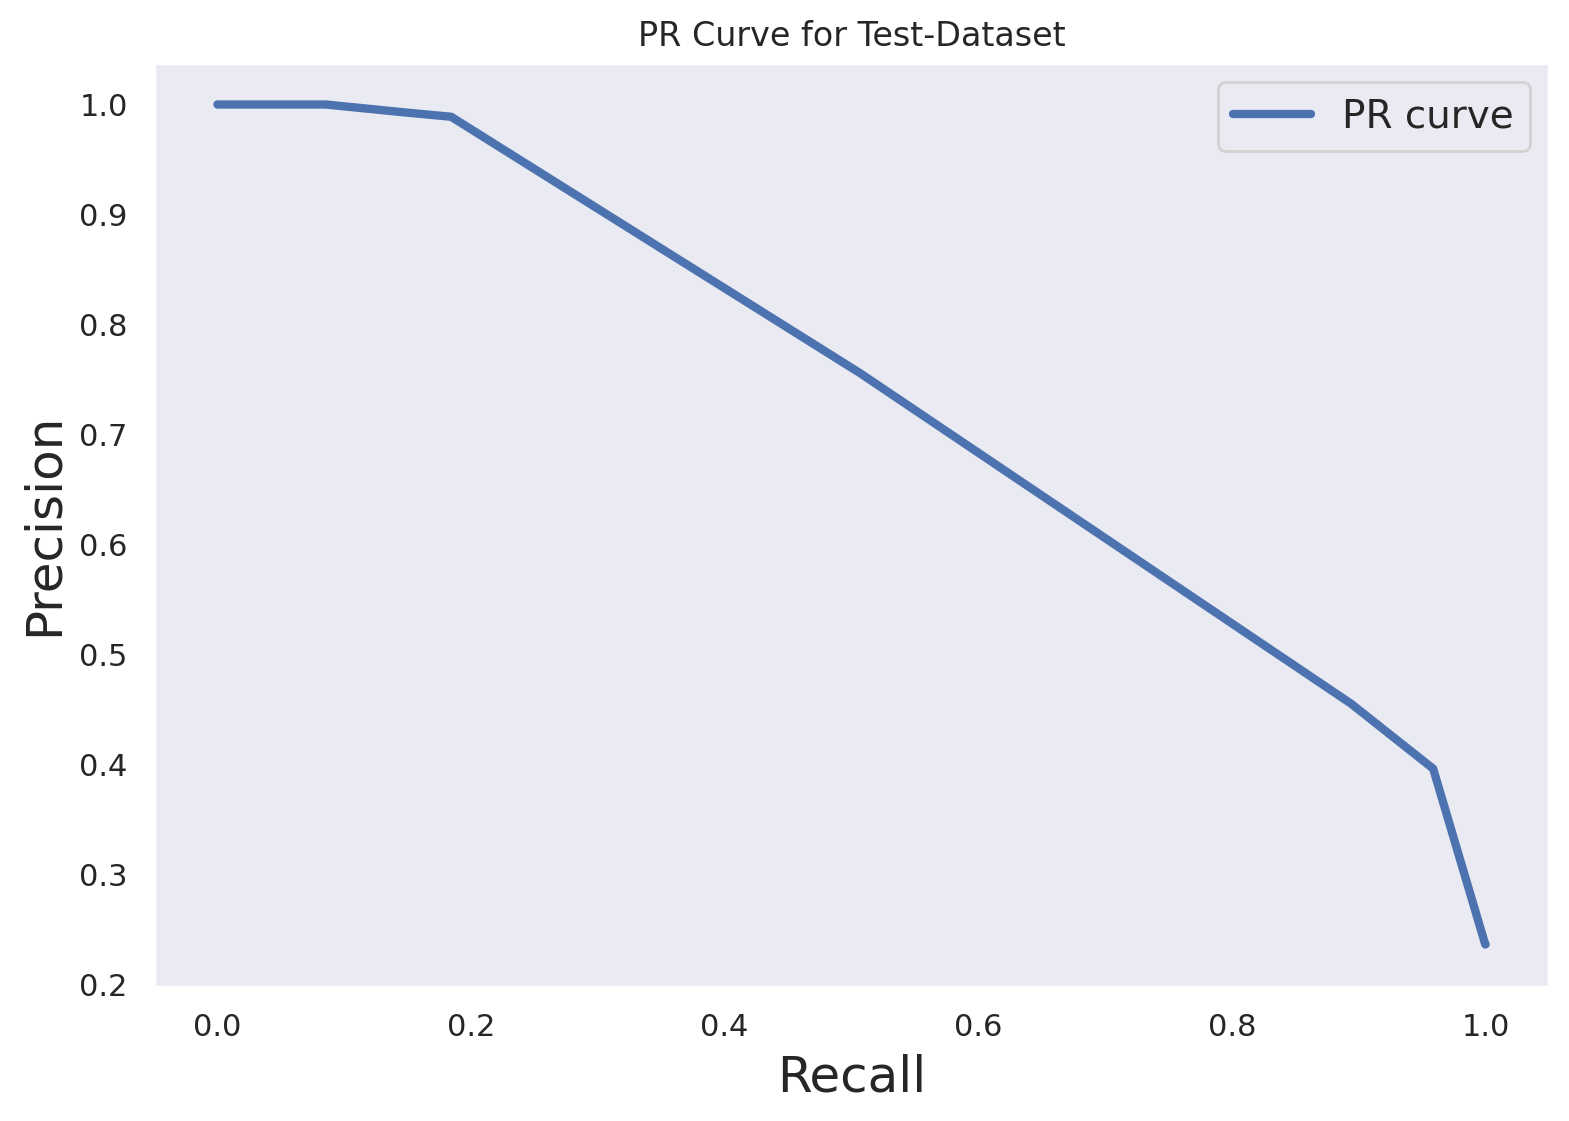

In [342]:
precision, recall, _ = precision_recall_curve(y_test, tree_predictions_proba[:, 1])

plt.plot(recall, precision, linewidth=3, label='PR curve')
plt.title('PR Curve for Test-Dataset')
plt.xlabel('Recall', size=18)
plt.ylabel('Precision', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

In [343]:
average_precision_sc = average_precision_score(y_test, tree_predictions_proba[:, 1])
print(f'Average Precision Score: {average_precision_sc}')  # 0.64

# Значение average precision score приблизительно 0.64.
# Это указывает на то, что модель не очень хорошо предсказывает положительные классы (людей с доходом от 50к в год).
# С ростом recall модель начинает выдавать очень много ложных позитивных ответов
# Снова заметна проблема небольшого количества пороговых значений вероятности

Average Precision Score: 0.638796314804034


Теперь посмотрим на работу дерева на следующих стандартных датасетах.

### **Задание 7 (2 балла).**

Даны следующие датасеты из sklearn. Для начала нарисуйте их через `scatter`, каждый в отдельности. И обучите `DecisionTreeClassifier` с `random_state=17` на каждом датасете. Получите значения меток классов на тестовых данных. Чему равна метрика `Accuracy` для каждого случая? Затем покажите графически результат работы моделей через `plot_decision_regions`.

В этом задании предпочтительнее использовать цикл, чтобы не писать одинаковый код несколько раз. Попробуйте сделать именно так.

Какие выводы можно сделать? Есть ли признаки переобучения деревьев? Если да, то какие? И что можно сделать в случае, если дерево переобучается?

In [344]:
# уже готовые датасеты

datasets = [
    make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=17),
    make_moons(n_samples=1000, noise=0.1, random_state=17),
    make_classification(n_samples=1000, n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=17,
                        n_redundant=0)
]

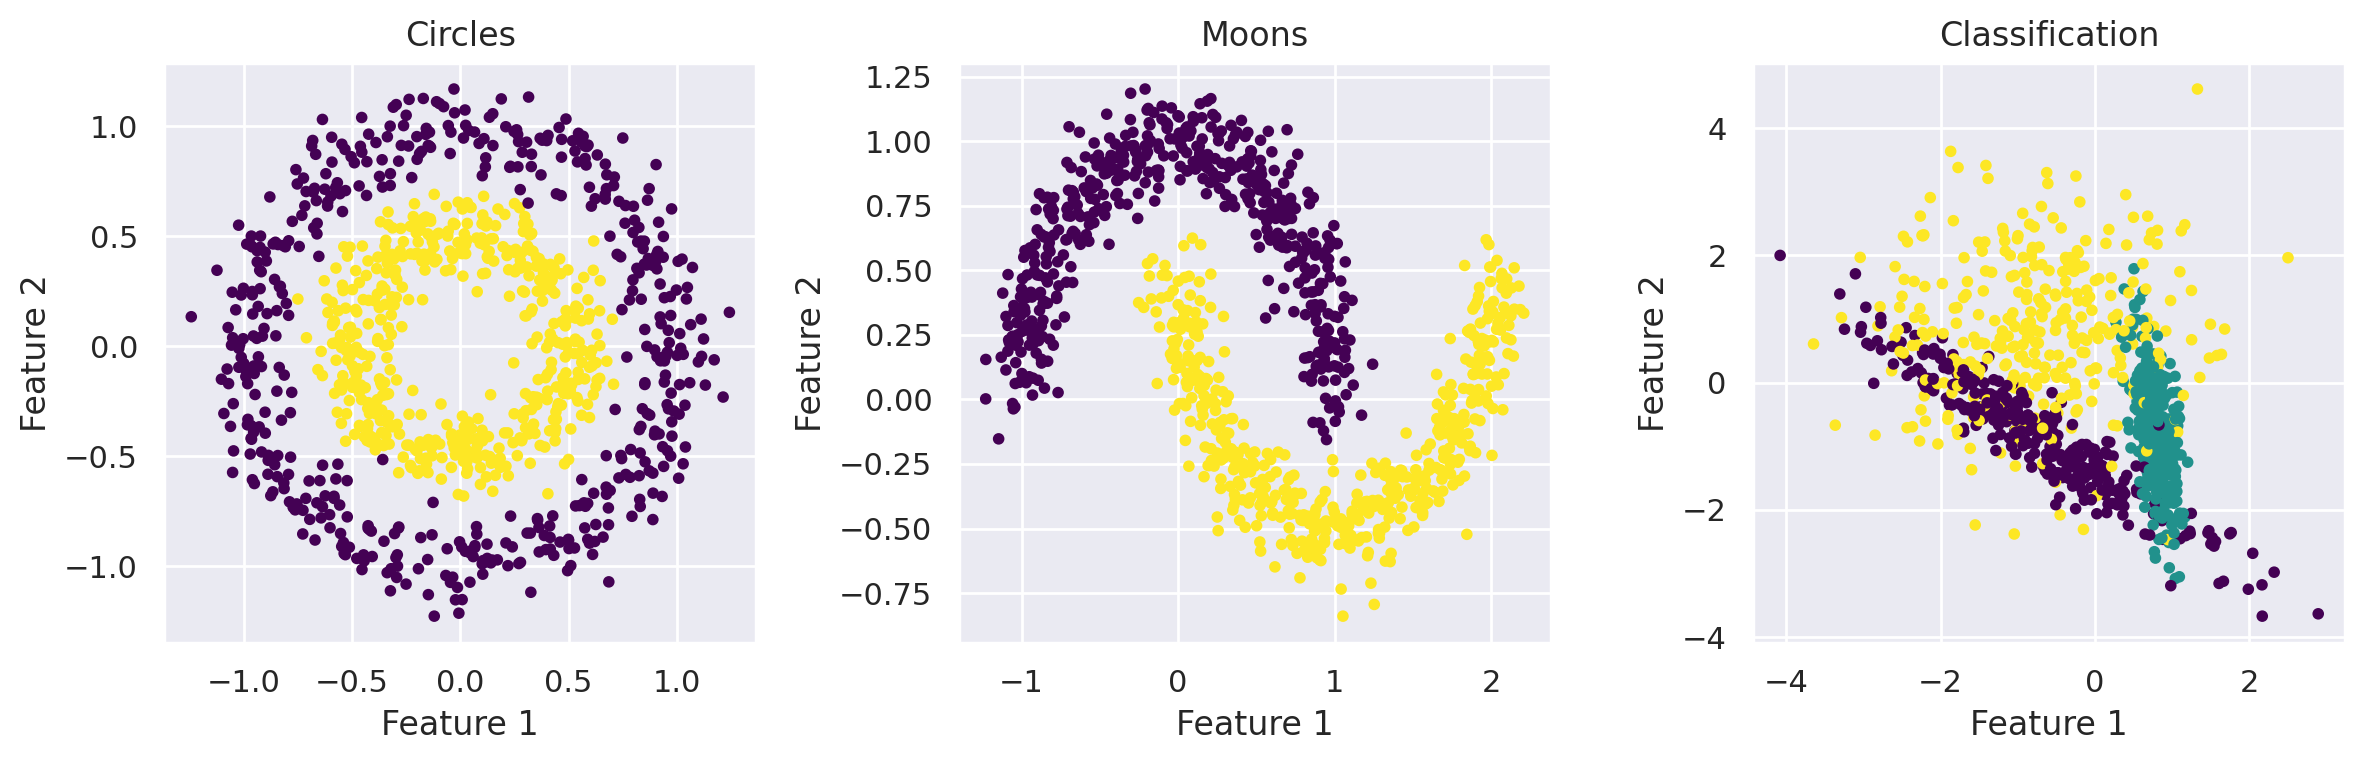

In [345]:
figure, axes = plt.subplots(1, 3, figsize=(12, 4))
names = ['Circles', 'Moons', 'Classification']

for i, (X, y) in enumerate(datasets):
  axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
  axes[i].set_title(names[i])
  axes[i].set_xlabel('Feature 1')
  axes[i].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [346]:
arr_datasets = []  # будем хранить тренировочные и тестовые данные для каждого датасета
arr_trees = []
accuracies = []
for i in range(3):
    arr_datasets.append(train_test_split(datasets[i][0], datasets[i][1], test_size=0.25, random_state=17))
    X_train, X_test, y_train, y_test = arr_datasets[i]

    arr_trees.append(DecisionTreeClassifier(random_state=17))
    arr_trees[i].fit(X_train, y_train)

    predictions = arr_trees[i].predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

print(accuracies)  # 0.992 - для первого, 0.992 - для второго, 0.772 - для третьего (считается только на тестовых данных)

[0.992, 0.992, 0.772]


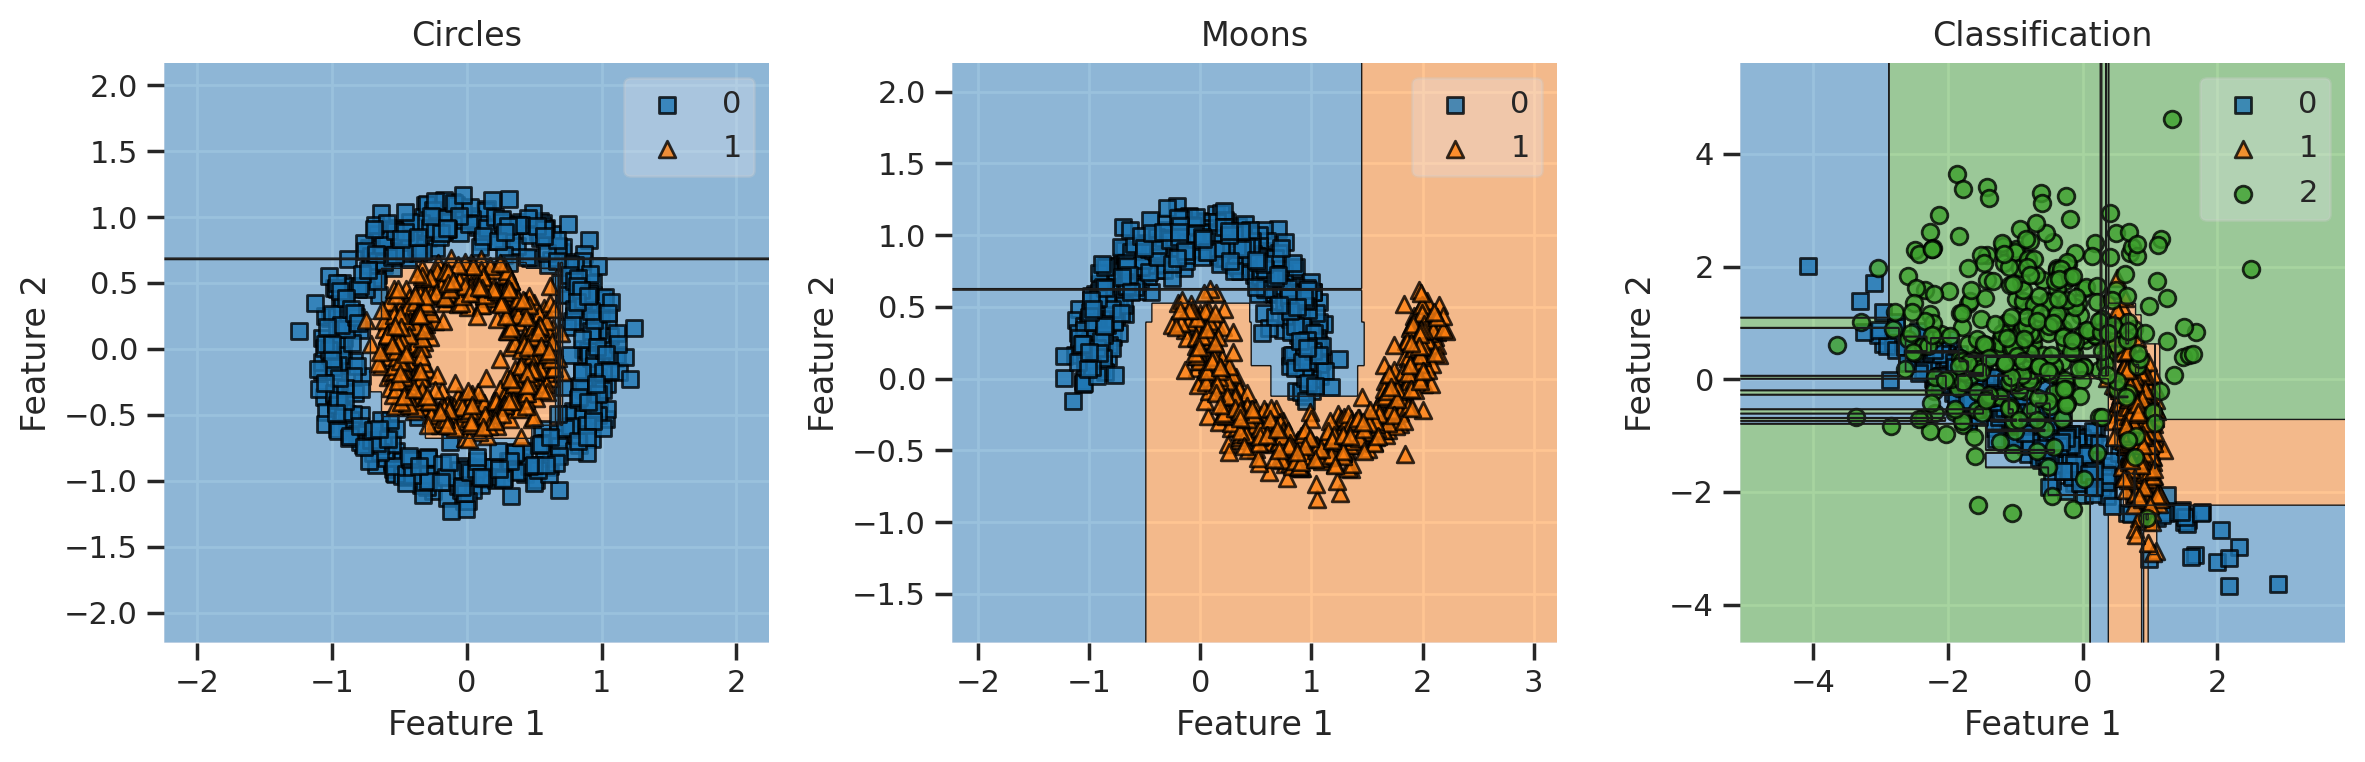

In [347]:
figure, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    X = datasets[i][0]
    y = datasets[i][1]
    plot_decision_regions(X, y, clf=arr_trees[i], ax=axes[i])
    axes[i].set_title(names[i])
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

<Axes: >

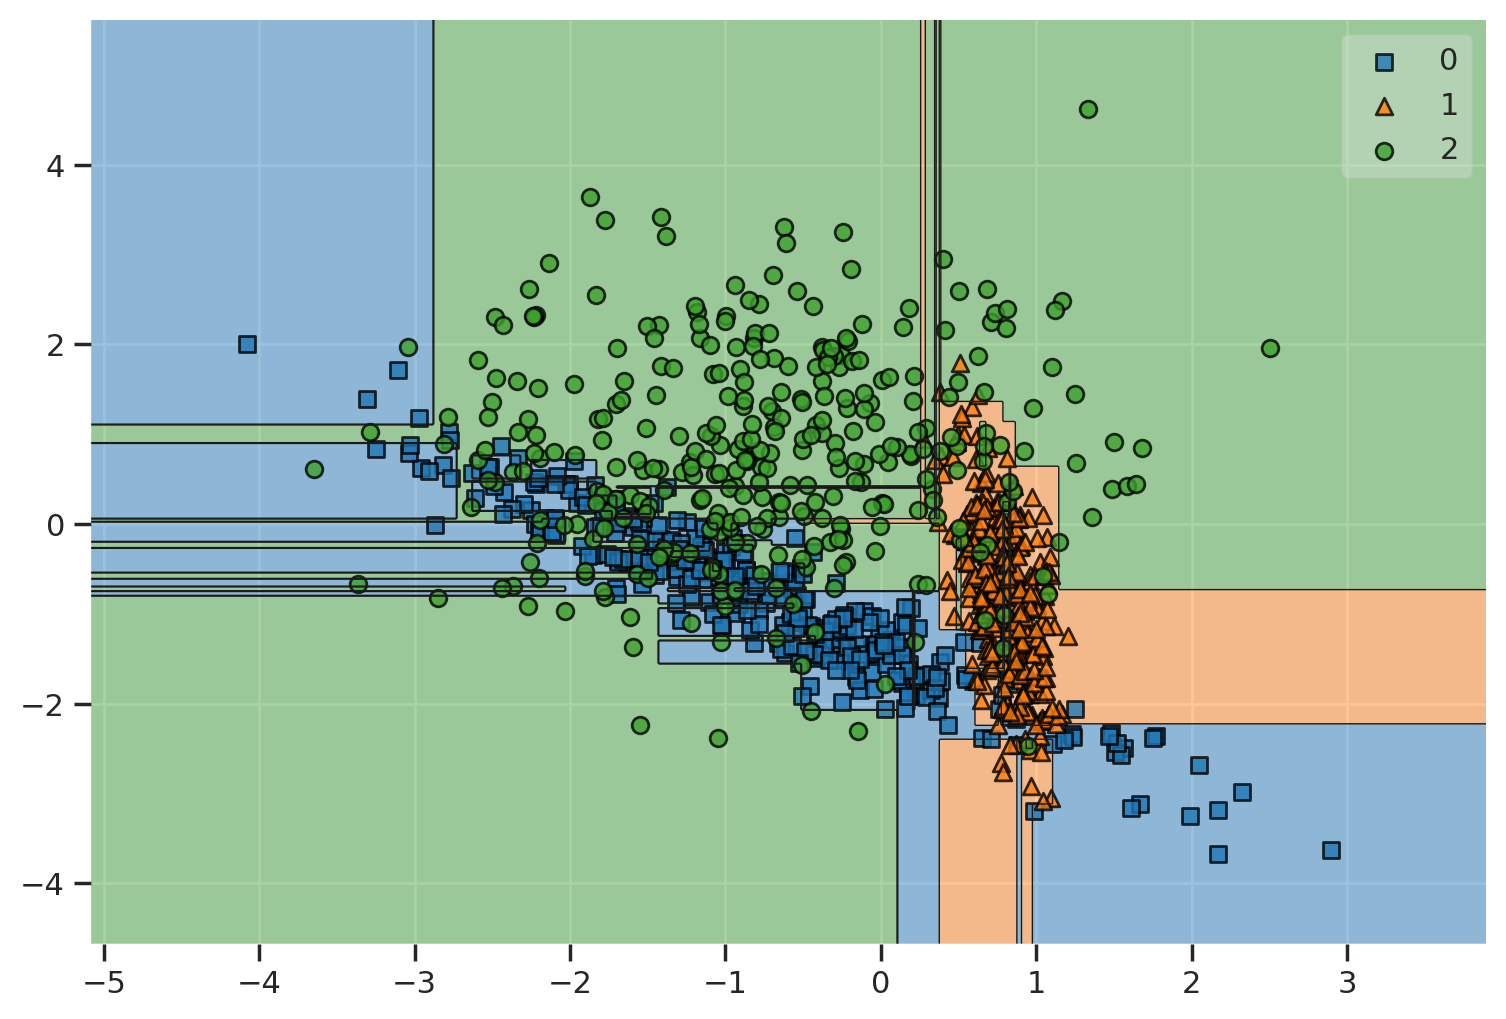

In [348]:
# Первые два дерева отлично справляются, признаков переобучения нет (областей немного, хороший результат на тестовой выборке) посмотрим внимательнее на третье:
plot_decision_regions(datasets[2][0], datasets[2][1], clf=arr_trees[2])


# Это дерево переобучено, признаки переобучения:
# 1) Очень много сложных областей
# 2) Много маленьких областей, которые рисуются, чтобы "подстроиться" под обучающую выборку
# 3) плохие результаты на тестовой выборке (достаточно низкий accuracy)

# Чтобы избавиться от переобучения можно:
# 1) Изменить гиперпараметры дерева, например требовать большее число минимального количества объектов в листе дерева (чтобы не было чего-то сверх специфичного),
# можно урезать глубину дерева, уставновить максимальное количество листьев в дереве
# 2) Использовать кросс-валидацию, это обеспечит более качественное обучение на большем количестве данных
# 3) Удалить или изменить часть признаков
# 4) Прекратить обучение, когда модель начинает слишком сильно подстраиваться под обучающую выборку